<a href="https://colab.research.google.com/github/rkkapali/ferjaffetraining/blob/main/ferjaffetraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Drive, importing, checking and loading datasets and targetting emotions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive"

 1.jpeg						 PublicTest_22986053.jpg
 234.png					 PublicTest_23216863.jpg
'2nd Lab session of CO3519 module (AI).gdoc'	 PublicTest_23583223.jpg
'3in by 3in grid.gdoc'				 PublicTest_24449829.jpg
'3in by 3in grid.odt'				 PublicTest_24738517.jpg
 7.png						 PublicTest_2615422.jpg
 7x7						 PublicTest_3012169.jpg
'7x7 (1).docx'					 PublicTest_38966726.jpg
'7x7 (2).docx'					 PublicTest_39373170.jpg
'7x7cm (1) (1).docx'				 PublicTest_40148704.jpg
'7x7cm (1).docx'				 PublicTest_40559227.jpg
 7x7cm.gdoc					 PublicTest_43801413.jpg
 7x7.docx					 PublicTest_44179455.jpg
'archive (2)'					 PublicTest_45297572.jpg
 assignment.sln					 PublicTest_46006432.jpg
'Binu Level 3.gdoc'				 PublicTest_46144482.jpg
'Binu Level 3.pdf'				 PublicTest_46372964.jpg
'Book 09-06-2022 11.30_5.jpg'			 PublicTest_46663858.jpg
'Book 09-06-2022 11.30_6 (1).jpg'		 PublicTest_46713098.jpg
'Book 09-06-2022 11.30_6.jpg'			 PublicTest_46929671.jpg
'Book 09-06-2022 11.30_7.jpg'			 PublicTest_47060827.jpg
 CK_dat

In [ ]:
# Importing all libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten  # Added Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import cv2
import os
import kagglehub

path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, horizontal_flip=True, fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    classes=target_emotions
)

print("Found images:", train_generator.samples)
print("Classes:", train_generator.class_indices)

Found 28273 images belonging to 6 classes.
Found images: 28273
Classes: {'neutral': 0, 'angry': 1, 'happy': 2, 'surprise': 3, 'sad': 4, 'fear': 5}


In [ ]:
jaffe_base_path = '/content/drive/MyDrive/JAFFE-[70,30]/JAFFE-[70,30]'
target_emotions = ['neutral', 'angry', 'happy', 'surprise', 'sad', 'fear']

In [ ]:
# Emotion mapping function
def get_emotion_from_filename(filename):
    code = filename.split('.')[1][:2]  # e.g., 'KA.AN1.39.tiff' -> 'AN'
    mapping = {'NE': 'neutral', 'AN': 'angry', 'HA': 'happy', 'SU': 'surprise', 'SA': 'sad', 'FE': 'fear'}
    return mapping.get(code, None)

In [ ]:
# Loading images and labels
jaffe_images = []
jaffe_labels = []

print(f"Checking path: {jaffe_base_path}")
if os.path.exists(jaffe_base_path):
    print("Contents:", os.listdir(jaffe_base_path)[:5])
else:
    print("Error: Path not found")
    raise FileNotFoundError("Update jaffe_base_path")

for subfolder in ['train', 'test']:
    subfolder_path = os.path.join(jaffe_base_path, subfolder)
    if os.path.isdir(subfolder_path):
        for emotion_folder in os.listdir(subfolder_path):
            emotion_path = os.path.join(subfolder_path, emotion_folder)
            if os.path.isdir(emotion_path) and emotion_folder.lower() in target_emotions:
                for filename in os.listdir(emotion_path):
                    if filename.endswith(('.tiff', '.tif', '.jpg', '.png', '.jpeg', '.TIFF', '.TIF')):
                        img_path = os.path.join(emotion_path, filename)
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is None:
                            print(f"Failed to load: {img_path}")
                            continue
                        img = cv2.resize(img, (48, 48))
                        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                        jaffe_images.append(img)
                        jaffe_labels.append(target_emotions.index(emotion_folder.lower()))
                    else:
                        print(f"Skipping {filename}: Unknown extension")
            else:
                print(f"Skipping {emotion_path}: Not a target emotion folder")
    else:
        print(f"Error: {subfolder_path} not found")

Checking path: /content/drive/MyDrive/JAFFE-[70,30]/JAFFE-[70,30]
Contents: ['test', 'train']


In [ ]:
# Convertiing to arrays and split
if not jaffe_images:
    print("Error: No images loaded. Check folder structure or file extensions.")
else:
    jaffe_images = np.array(jaffe_images) / 255.0
    jaffe_labels = tf.keras.utils.to_categorical(jaffe_labels, num_classes=6)
    print(f"Loaded {len(jaffe_images)} images")
    X_train_jaffe, X_test_jaffe, y_train_jaffe, y_test_jaffe = train_test_split(
        jaffe_images, jaffe_labels, test_size=0.2, random_state=42
    )
    print("JAFFE Train Samples:", X_train_jaffe.shape[0])
    print("JAFFE Test Samples:", X_test_jaffe.shape[0])

Loaded 183 images
JAFFE Train Samples: 146
JAFFE Test Samples: 37


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# fER-2013 paths
fer_base_path = '/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1'
train_dir = os.path.join(fer_base_path, 'train')
test_dir = os.path.join(fer_base_path, 'test')
target_emotions = ['neutral', 'angry', 'happy', 'surprise', 'sad', 'fear']

#generators
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, horizontal_flip=True, fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    classes=target_emotions
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    classes=target_emotions,
    shuffle=False
)

# printing sample counts
print("Train samples:", train_generator.samples)
print("Test samples:", test_generator.samples)
print("Train classes:", train_generator.class_indices)
print("Test classes:", test_generator.class_indices)
print("Steps per epoch:", max(1, train_generator.samples // 32))
print("Validation steps:", max(1, test_generator.samples // 32))

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.
Train samples: 28273
Test samples: 7067
Train classes: {'neutral': 0, 'angry': 1, 'happy': 2, 'surprise': 3, 'sad': 4, 'fear': 5}
Test classes: {'neutral': 0, 'angry': 1, 'happy': 2, 'surprise': 3, 'sad': 4, 'fear': 5}
Steps per epoch: 883
Validation steps: 220


In [ ]:
import os

print(f"Train dir: {train_dir}")
print("Exists:", os.path.isdir(train_dir))
if os.path.isdir(train_dir):
    print("Contents:", os.listdir(train_dir))
    for emotion in target_emotions:
        emotion_path = os.path.join(train_dir, emotion)
        if os.path.isdir(emotion_path):
            print(f"  {emotion}: {len(os.listdir(emotion_path))} files")
        else:
            print(f"  {emotion}: Not found")

print(f"\nTest dir: {test_dir}")
print("Exists:", os.path.isdir(test_dir))
if os.path.isdir(test_dir):
    print("Contents:", os.listdir(test_dir))
    for emotion in target_emotions:
        emotion_path = os.path.join(test_dir, emotion)
        if os.path.isdir(emotion_path):
            print(f"  {emotion}: {len(os.listdir(emotion_path))} files")
        else:
            print(f"  {emotion}: Not found")

Train dir: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train
Exists: True
Contents: ['fear', 'neutral', 'angry', 'disgust', 'surprise', 'happy', 'sad']
  neutral: 4965 files
  angry: 3995 files
  happy: 7215 files
  surprise: 3171 files
  sad: 4830 files
  fear: 4097 files

Test dir: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test
Exists: True
Contents: ['fear', 'neutral', 'angry', 'disgust', 'surprise', 'happy', 'sad']
  neutral: 1233 files
  angry: 958 files
  happy: 1774 files
  surprise: 831 files
  sad: 1247 files
  fear: 1024 files


In [ ]:
import os

#jaffe path
jaffe_path = '/content/drive/MyDrive/JAFFE-[70,30]/JAFFE-[70,30]'  # Update if needed
target_emotions = ['neutral', 'angry', 'happy', 'surprise', 'sad', 'fear']

print(f"JAFFE path: {jaffe_path}")
print("Exists:", os.path.exists(jaffe_path))
if os.path.exists(jaffe_path):
    contents = os.listdir(jaffe_path)
    print("Contents:", contents)

    # checking subfolders (train/test)
    subfolders = [f for f in contents if os.path.isdir(os.path.join(jaffe_path, f))]
    print("Subfolders:", subfolders)

    # inspecting train and test, then their emotion subfolders
    for subfolder in subfolders:
        subfolder_path = os.path.join(jaffe_path, subfolder)
        emotion_folders = os.listdir(subfolder_path)
        print(f"\nContents of {subfolder}:", emotion_folders)

        # checking each emotion folder for images
        for emotion in emotion_folders:
            emotion_path = os.path.join(subfolder_path, emotion)
            if os.path.isdir(emotion_path):
                files = os.listdir(emotion_path)
                image_files = [f for f in files if f.endswith(('.tiff', '.tif', '.TIFF', '.TIF', '.png', '.jpg', '.jpeg'))]
                print(f"  {emotion}: {len(image_files)} image files")
                if image_files:
                    print(f"    Sample images: {image_files[:5]}")
                else:
                    print(f"    No image files found in {emotion}")
            else:
                print(f"  {emotion}: Not a directory")
else:
    print("Error: JAFFE path not found. Update jaffe_path.")

JAFFE path: /content/drive/MyDrive/JAFFE-[70,30]/JAFFE-[70,30]
Exists: True
Contents: ['test', 'train']
Subfolders: ['test', 'train']

Contents of test: ['Sad', 'Neutral', 'Happy', 'Surprise', 'Fear', 'Angry']
  Sad: 9 image files
    Sample images: ['YM.SA1.55.tiff', 'TM.SA1.184.tiff', 'TM.SA3.186.tiff', 'YM.SA3.57.tiff', 'YM.SA2.56.tiff']
  Neutral: 9 image files
    Sample images: ['TM.NE1.177.tiff', 'UY.NE1.134.tiff', 'TM.NE3.179.tiff', 'UY.NE2.135.tiff', 'TM.NE2.178.tiff']
  Happy: 9 image files
    Sample images: ['UY.HA3.139.tiff', 'YM.HA1.52.tiff', 'YM.HA3.54.tiff', 'YM.HA2.53.tiff', 'TM.HA3.182.tiff']
  Surprise: 9 image files
    Sample images: ['YM.SU3.60.tiff', 'TM.SU2.188.tiff', 'YM.SU2.59.tiff', 'TM.SU1.187.tiff', 'UY.SU1.143.tiff']
  Fear: 10 image files
    Sample images: ['TM.FE2.197.tiff', 'YM.FE4.70.tiff', 'YM.FE3.69.tiff', 'YM.FE2.68.tiff', 'TM.FE3.198.tiff']
  Angry: 9 image files
    Sample images: ['TM.AN3.192.tiff', 'UY.AN1.146.tiff', 'TM.AN2.191.tiff', 'YM.AN1.

In [ ]:
jaffe_images = []
jaffe_labels = []

for subfolder in ['train', 'test']:
    subfolder_path = os.path.join(jaffe_path, subfolder)
    for emotion in os.listdir(subfolder_path):
        emotion_path = os.path.join(subfolder_path, emotion)
        if os.path.isdir(emotion_path) and emotion.lower() in target_emotions:
            for filename in os.listdir(emotion_path):
                if filename.endswith(('.tiff', '.tif', '.TIFF', '.TIF')):  # Update extensions based on output
                    img_path = os.path.join(emotion_path, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (48, 48))
                        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                        jaffe_images.append(img)
                        jaffe_labels.append(target_emotions.index(emotion.lower()))

In [ ]:
train_dir = os.path.join(fer_base_path, 'train')
test_dir = os.path.join(fer_base_path, 'test')
target_emotions = ['neutral', 'angry', 'happy', 'surprise', 'sad', 'fear']

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, horizontal_flip=True, fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(48, 48), batch_size=32, class_mode='categorical', color_mode='rgb', classes=target_emotions)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(48, 48), batch_size=32, class_mode='categorical', color_mode='rgb', classes=target_emotions, shuffle=False)

print("FER-2013 Train Samples:", train_generator.samples)
print("FER-2013 Test Samples:", test_generator.samples)

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.
FER-2013 Train Samples: 28273
FER-2013 Test Samples: 7067


# First model: Restnet50

In [ ]:
# first model for jaffe
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# training on fer 2013
steps_per_epoch = max(1, train_generator.samples // 32)
validation_steps = max(1, test_generator.samples // 32)
print(f"Training with {steps_per_epoch} steps/epoch, {validation_steps} validation steps")

history_fer = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)
model.save('/content/drive/MyDrive/fer_model.h5')

Training with 883 steps/epoch, 220 validation steps
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


883/883 ━━━━━━━━━━━━━━━━━━━━ 397s 439ms/step - accuracy: 0.2346 - loss: 1.7982 - val_accuracy: 0.2520 - val_loss: 1.7576
Epoch 2/10
  1/883 ━━━━━━━━━━━━━━━━━━━━ 3:58 270ms/step - accuracy: 0.2500 - loss: 1.7748

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


883/883 ━━━━━━━━━━━━━━━━━━━━ 70s 79ms/step - accuracy: 0.2500 - loss: 1.7748 - val_accuracy: 0.2520 - val_loss: 1.7576
Epoch 3/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 384s 435ms/step - accuracy: 0.2538 - loss: 1.7578 - val_accuracy: 0.2520 - val_loss: 1.7563
Epoch 4/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 82s 93ms/step - accuracy: 0.2500 - loss: 1.7982 - val_accuracy: 0.2520 - val_loss: 1.7566
Epoch 5/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 442s 460ms/step - accuracy: 0.2571 - loss: 1.7567 - val_accuracy: 0.2520 - val_loss: 1.7563
Epoch 6/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 81s 91ms/step - accuracy: 0.3125 - loss: 1.7801 - val_accuracy: 0.2520 - val_loss: 1.7563
Epoch 7/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 384s 434ms/step - accuracy: 0.2543 - loss: 1.7557 - val_accuracy: 0.2520 - val_loss: 1.7596
Epoch 8/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 69s 78ms/step - accuracy: 0.2500 - loss: 1.7303 - val_accuracy: 0.2520 - val_loss: 1.7596
Epoch 9/10
883/883 ━━━━━━━━━━━━━━━━━━━━ 382s 433ms/step - accuracy: 0.2540 - loss: 1.7575 - val

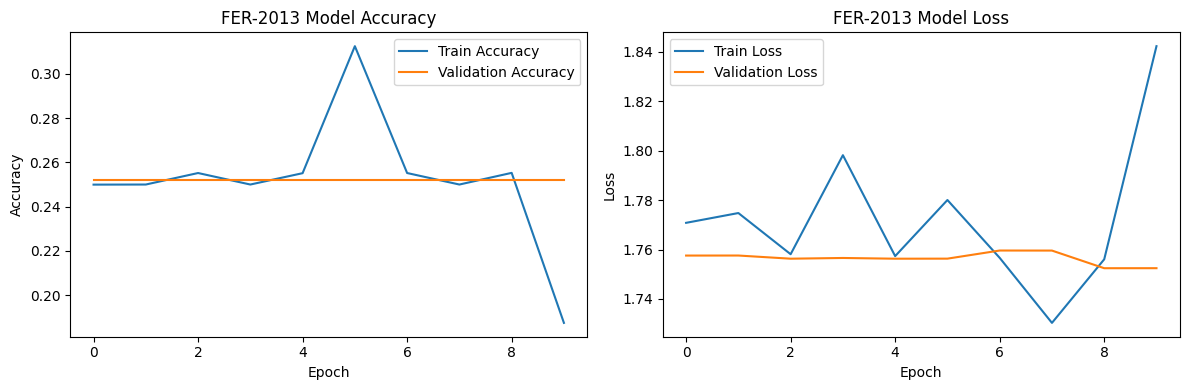

221/221 ━━━━━━━━━━━━━━━━━━━━ 79s 349ms/step


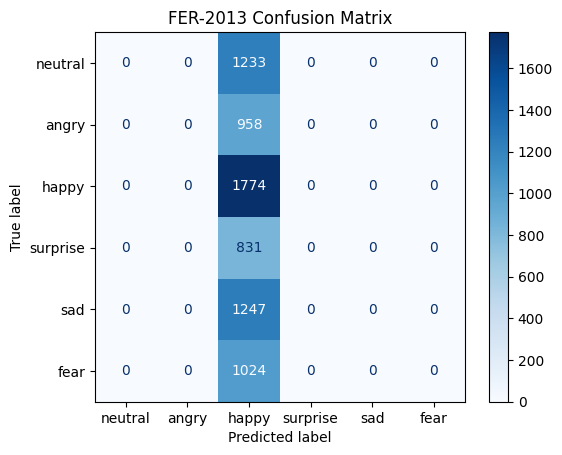

221/221 ━━━━━━━━━━━━━━━━━━━━ 76s 342ms/step - accuracy: 0.2130 - loss: 1.7168
FER-2013 Test Accuracy: 0.2510


In [ ]:
# evaluating fer2013
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fer.history['accuracy'], label='Train Accuracy')
plt.plot(history_fer.history['val_accuracy'], label='Validation Accuracy')
plt.title('FER-2013 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_fer.history['loss'], label='Train Loss')
plt.plot(history_fer.history['val_loss'], label='Validation Loss')
plt.title('FER-2013 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/fer_accuracy_loss.png')
plt.show()

y_pred_fer = model.predict(test_generator)
y_pred_classes_fer = np.argmax(y_pred_fer, axis=1)
y_true_fer = test_generator.classes
cm_fer = confusion_matrix(y_true_fer, y_pred_classes_fer)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_fer, display_labels=target_emotions)
disp.plot(cmap=plt.cm.Blues)
plt.title('FER-2013 Confusion Matrix')
plt.savefig('/content/drive/MyDrive/fer_confusion_matrix.png')
plt.show()

test_loss_fer, test_accuracy_fer = model.evaluate(test_generator)
print(f"FER-2013 Test Accuracy: {test_accuracy_fer:.4f}")

In [ ]:
# training jaffe
jaffe_steps_per_epoch = max(1, len(X_train_jaffe) // 32)
jaffe_validation_steps = max(1, len(X_test_jaffe) // 32)
print(f"JAFFE: Training with {jaffe_steps_per_epoch} steps/epoch, {jaffe_validation_steps} validation steps")

history_jaffe = model.fit(
    X_train_jaffe, y_train_jaffe,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_jaffe, y_test_jaffe)
)
model.save('/content/drive/MyDrive/fer_jaffe_model.h5')

JAFFE: Training with 4 steps/epoch, 1 validation steps
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step - accuracy: 0.1727 - loss: 1.8191 - val_accuracy: 0.2162 - val_loss: 1.7910
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step - accuracy: 0.1471 - loss: 1.8256 - val_accuracy: 0.2162 - val_loss: 1.7908
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 0.1567 - loss: 1.8200 - val_accuracy: 0.2162 - val_loss: 1.7906
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 570ms/step - accuracy: 0.1567 - loss: 1.8247 - val_accuracy: 0.2162 - val_loss: 1.7903
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step - accuracy: 0.1745 - loss: 1.8187 - val_accuracy: 0.2162 - val_loss: 1.7901
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 0.1892 - loss: 1.8018 - val_accuracy: 0.2162 - val_loss: 1.7898
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 430ms/step - accuracy: 0.1480 - loss: 1.8130 - val_accuracy: 0.2162 - val_loss: 1.7895
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 592ms/step - accuracy: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


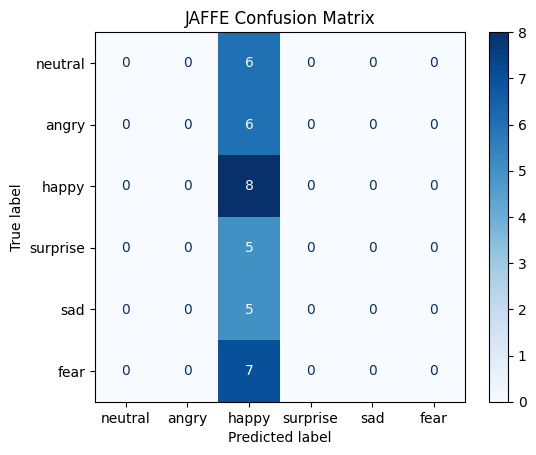

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2171 - loss: 1.7931
JAFFE Test Accuracy: 0.2162


In [ ]:
# evaluating jaffe
y_pred_jaffe = model.predict(X_test_jaffe)
y_pred_classes_jaffe = np.argmax(y_pred_jaffe, axis=1)
y_true_jaffe = np.argmax(y_test_jaffe, axis=1)
cm_jaffe = confusion_matrix(y_true_jaffe, y_pred_classes_jaffe)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_jaffe, display_labels=target_emotions)
disp.plot(cmap=plt.cm.Blues)
plt.title('JAFFE Confusion Matrix')
plt.savefig('/content/drive/MyDrive/jaffe_confusion_matrix.png')
plt.show()

test_loss_jaffe, test_accuracy_jaffe = model.evaluate(X_test_jaffe, y_test_jaffe)
print(f"JAFFE Test Accuracy: {test_accuracy_jaffe:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


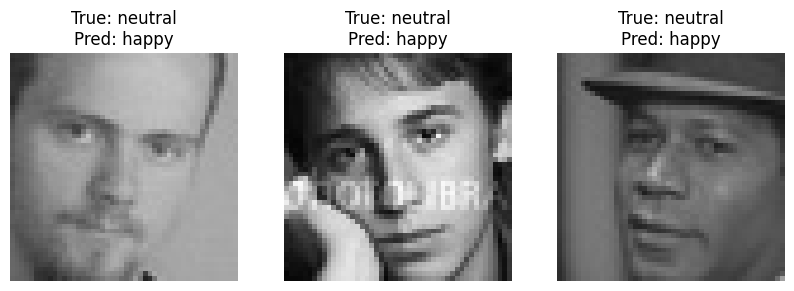

In [ ]:
# fer2013 predictions
test_images, test_labels = next(test_generator)
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(test_images[i])
    true_label = target_emotions[true_classes[i]]
    pred_label = target_emotions[predicted_classes[i]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.savefig('/content/drive/MyDrive/fer_sample_predictions.png')
plt.show()

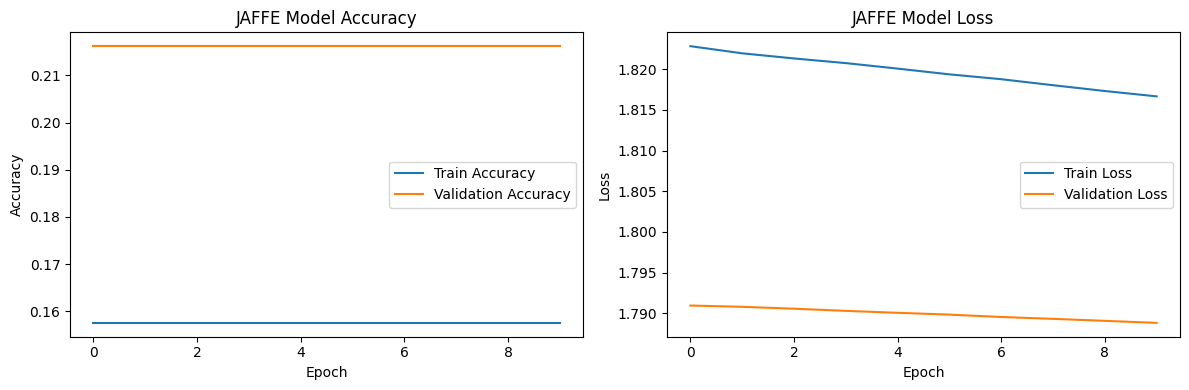

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


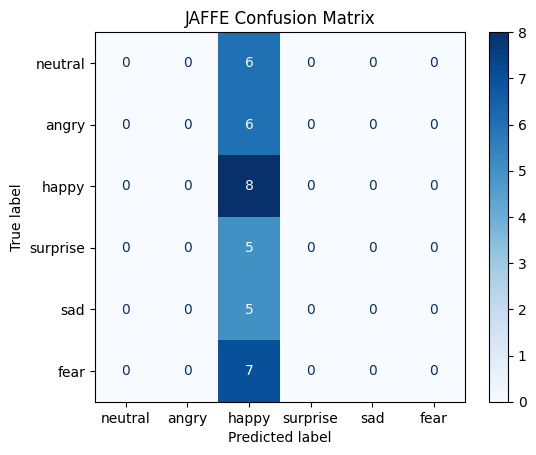

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.2171 - loss: 1.7905
JAFFE Test Accuracy: 0.2162


In [ ]:
# plotting for jaffe model accuracy , loss and confusion matrix
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_jaffe.history['accuracy'], label='Train Accuracy')
plt.plot(history_jaffe.history['val_accuracy'], label='Validation Accuracy')
plt.title('JAFFE Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_jaffe.history['loss'], label='Train Loss')
plt.plot(history_jaffe.history['val_loss'], label='Validation Loss')
plt.title('JAFFE Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/jaffe_accuracy_loss.png')
plt.show()

y_pred_jaffe = model.predict(X_test_jaffe)
y_pred_classes_jaffe = np.argmax(y_pred_jaffe, axis=1)
y_true_jaffe = np.argmax(y_test_jaffe, axis=1)
cm_jaffe = confusion_matrix(y_true_jaffe, y_pred_classes_jaffe)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_jaffe, display_labels=target_emotions)
disp.plot(cmap=plt.cm.Blues)
plt.title('JAFFE Confusion Matrix')
plt.savefig('/content/drive/MyDrive/jaffe_confusion_matrix.png')
plt.show()

test_loss_jaffe, test_accuracy_jaffe = model.evaluate(X_test_jaffe, y_test_jaffe)
print(f"JAFFE Test Accuracy: {test_accuracy_jaffe:.4f}")

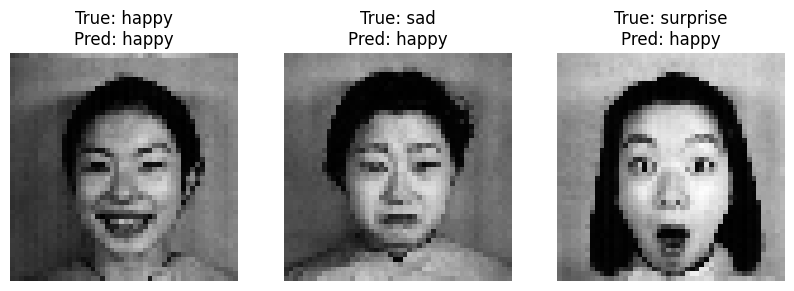

In [ ]:
# jaffe predictions
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(X_test_jaffe[i])
    true_label = target_emotions[np.argmax(y_test_jaffe[i])]
    pred_label = target_emotions[np.argmax(y_pred_jaffe[i])]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.savefig('/content/drive/MyDrive/jaffe_sample_predictions.png')
plt.show()

# Creating custom restnet18 for better accuracy

In [ ]:
import os

save_dir = '/content/drive/MyDrive/'

# list of expected files
expected_files = [
    'fer_jaffe_model.h5',
    'fer_accuracy_loss.png',
    'fer_confusion_matrix.png',
    'jaffe_accuracy_loss.png',
    'jaffe_confusion_matrix.png',
    'fer_sample_predictions.png',
    'jaffe_sample_predictions.png'
]

# checking
print("Checking for saved files in", save_dir)
for file in expected_files:
    file_path = os.path.join(save_dir, file)
    if os.path.exists(file_path):
        print(f"✓ {file} exists")
    else:
        print(f"✗ {file} is missing")

Checking for saved files in /content/drive/MyDrive/
✓ fer_jaffe_model.h5 exists
✓ fer_accuracy_loss.png exists
✓ fer_confusion_matrix.png exists
✓ jaffe_accuracy_loss.png exists
✓ jaffe_confusion_matrix.png exists
✓ fer_sample_predictions.png exists
✓ jaffe_sample_predictions.png exists


In [ ]:
# custom resnet18 def
def residual_block(x, filters, kernel_size=3, stride=1, downsample=False):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    if downsample or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same', kernel_initializer='he_normal')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def ResNet18(input_shape=(48, 48, 3), classes=6):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 7, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    # residual blocks
    x = residual_block(x, 64)  # Stage 1
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2, downsample=True)  # Stage 2
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2, downsample=True)  # Stage 3
    x = residual_block(x, 256)
    x = residual_block(x, 512, stride=2, downsample=True)  # Stage 4
    x = residual_block(x, 512)

    return Model(inputs, x, name='resnet18')

In [ ]:
# resnet18 model
base_model = ResNet18(input_shape=(48, 48, 3), classes=6)
for layer in base_model.layers[:-10]:  # Unfreeze last 10 layers
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # More units, L2
x = Dropout(0.6)(x)  # Higher dropout
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fer2013 training
steps_per_epoch = train_generator.samples // 64
validation_steps = test_generator.samples // 64
history_fer = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/15
441/441 ━━━━━━━━━━━━━━━━━━━━ 103s 232ms/step - accuracy: 0.2576 - loss: 1.7415 - val_accuracy: 0.3741 - val_loss: 1.5997
Epoch 2/15
441/441 ━━━━━━━━━━━━━━━━━━━━ 141s 321ms/step - accuracy: 0.2592 - loss: 1.7369 - val_accuracy: 0.3378 - val_loss: 1.6378
Epoch 3/15
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.2031 - loss: 1.6767 - val_accuracy: 0.3227 - val_loss: 1.6358
Epoch 4/15
441/441 ━━━━━━━━━━━━━━━━━━━━ 144s 298ms/step - accuracy: 0.2612 - loss: 1.7210 - val_accuracy: 0.3205 - val_loss: 1.6538


In [ ]:
# jaffe training
history_jaffe = model.fit(
    X_train_jaffe, y_train_jaffe,
    epochs=15,
    batch_size=64,
    validation_data=(X_test_jaffe, y_test_jaffe),
    callbacks=[early_stopping]
)

Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step - accuracy: 0.1706 - loss: 1.7907 - val_accuracy: 0.2973 - val_loss: 1.7790
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - accuracy: 0.1691 - loss: 1.7815 - val_accuracy: 0.2432 - val_loss: 1.7762
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - accuracy: 0.1735 - loss: 1.7673 - val_accuracy: 0.1892 - val_loss: 1.7712
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 816ms/step - accuracy: 0.2385 - loss: 1.7415 - val_accuracy: 0.1351 - val_loss: 1.7581


In [ ]:
# evaluation of jaffe and fer
test_loss_fer, test_accuracy_fer = model.evaluate(test_generator)
print(f"FER-2013 Test Accuracy: {test_accuracy_fer:.4f}")
test_loss_jaffe, test_accuracy_jaffe = model.evaluate(X_test_jaffe, y_test_jaffe)
print(f"JAFFE Test Accuracy: {test_accuracy_jaffe:.4f}")

model.save('/content/drive/MyDrive/fer_jaffe_model_fast_cnn.h5')

221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.2176 - loss: 1.7833
FER-2013 Test Accuracy: 0.2563
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2919 - loss: 1.7805


JAFFE Test Accuracy: 0.2973


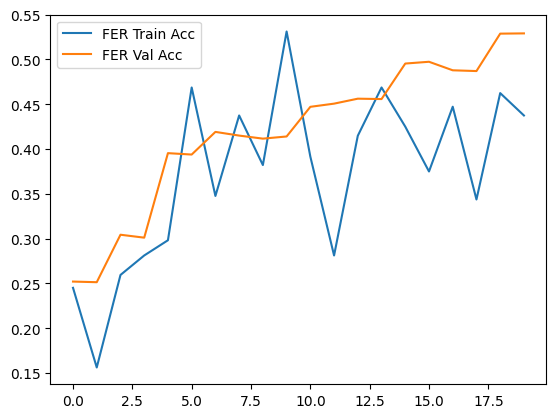

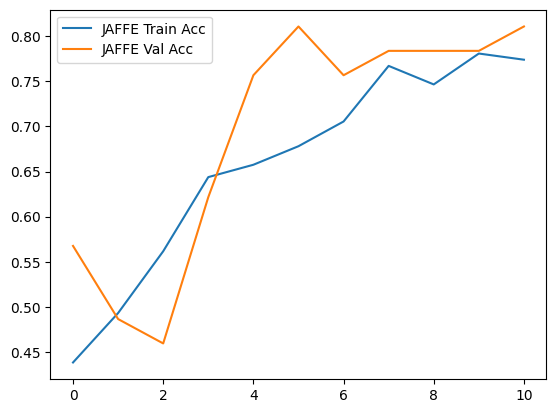

In [ ]:
plt.plot(history_fer.history['accuracy'], label='FER Train Acc')
plt.plot(history_fer.history['val_accuracy'], label='FER Val Acc')
plt.legend()
plt.show()
plt.plot(history_jaffe.history['accuracy'], label='JAFFE Train Acc')
plt.plot(history_jaffe.history['val_accuracy'], label='JAFFE Val Acc')
plt.legend()
plt.show()

# Using CNN

In [ ]:
#installing
!pip install matplotlib seaborn scikit-learn

# reimporting libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import cv2
import os
import kagglehub
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# remounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# for fer2013
fer_base_path = kagglehub.dataset_download("msambare/fer2013")
train_dir = os.path.join(fer_base_path, 'train')
test_dir = os.path.join(fer_base_path, 'test')
target_emotions = ['neutral', 'angry', 'happy', 'surprise', 'sad', 'fear']

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(48, 48), batch_size=32, class_mode='categorical',
    color_mode='rgb', classes=target_emotions)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(48, 48), batch_size=32, class_mode='categorical',
    color_mode='rgb', classes=target_emotions, shuffle=False)

print("FER-2013 Train Samples:", train_generator.samples)
print("FER-2013 Test Samples:", test_generator.samples)


Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.
FER-2013 Train Samples: 28273
FER-2013 Test Samples: 7067


In [ ]:
# checking jaffe
jaffe_path = '/content/drive/MyDrive/JAFFE-[70,30]/JAFFE-[70,30]'
jaffe_images = []
jaffe_labels = []

for subfolder in ['train', 'test']:
    subfolder_path = os.path.join(jaffe_path, subfolder)
    for emotion in os.listdir(subfolder_path):
        emotion_path = os.path.join(subfolder_path, emotion)
        if os.path.isdir(emotion_path) and emotion.lower() in target_emotions:
            for filename in os.listdir(emotion_path):
                if filename.endswith(('.tiff', '.tif', '.TIFF', '.TIF')):
                    img_path = os.path.join(emotion_path, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        print(f"Failed to load: {img_path}")
                        continue
                    img = cv2.resize(img, (48, 48))
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                    jaffe_images.append(img)
                    jaffe_labels.append(target_emotions.index(emotion.lower()))

jaffe_images = np.array(jaffe_images) / 255.0
jaffe_labels = tf.keras.utils.to_categorical(jaffe_labels, num_classes=6)
X_train_jaffe, X_test_jaffe, y_train_jaffe, y_test_jaffe = train_test_split(
    jaffe_images, jaffe_labels, test_size=0.2, random_state=42)

print("JAFFE Train Samples:", X_train_jaffe.shape[0])
print("JAFFE Test Samples:", X_test_jaffe.shape[0])


JAFFE Train Samples: 146
JAFFE Test Samples: 37


In [ ]:
# enhanced CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(6, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

#training fer2013
steps_per_epoch = train_generator.samples // 32
validation_steps = test_generator.samples // 32
history_fer = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

# training jaffe
history_jaffe = model.fit(
    X_train_jaffe, y_train_jaffe,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_jaffe, y_test_jaffe),
    callbacks=[early_stopping]
)

# evaluate
test_loss_fer, test_accuracy_fer = model.evaluate(test_generator)
print(f"FER-2013 Test Accuracy: {test_accuracy_fer:.4f}")
test_loss_jaffe, test_accuracy_jaffe = model.evaluate(X_test_jaffe, y_test_jaffe)
print(f"JAFFE Test Accuracy: {test_accuracy_jaffe:.4f}")

# save model
model.save('/content/drive/MyDrive/fer_jaffe_model_enhanced_cnn.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 6, 6, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 6, 6, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,277,254 (4.87 MB)

 Trainable params: 1,275,782 (4.87 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


883/883 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - accuracy: 0.2325 - loss: 1.8763 - val_accuracy: 0.2648 - val_loss: 1.7395
Epoch 2/20
  1/883 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.1562 - loss: 1.8363

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


883/883 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1562 - loss: 1.8363 - val_accuracy: 0.2658 - val_loss: 1.7468
Epoch 3/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 82s 93ms/step - accuracy: 0.2577 - loss: 1.7036 - val_accuracy: 0.2614 - val_loss: 1.5980
Epoch 4/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4062 - loss: 1.4839 - val_accuracy: 0.2622 - val_loss: 1.6105
Epoch 5/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 82s 93ms/step - accuracy: 0.3032 - loss: 1.6404 - val_accuracy: 0.3886 - val_loss: 1.5096
Epoch 6/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2812 - loss: 1.6377 - val_accuracy: 0.3916 - val_loss: 1.5029
Epoch 7/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.3557 - loss: 1.5777 - val_accuracy: 0.4166 - val_loss: 1.5415
Epoch 8/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5000 - loss: 1.4682 - val_accuracy: 0.4173 - val_loss: 1.5302
Epoch 9/20
883/883 ━━━━━━━━━━━━━━━━━━━━ 79s 47ms/step - accuracy: 0.3825 - loss: 1.5083 - val_accuracy: 0.312

JAFFE Test Accuracy: 0.8919


221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step


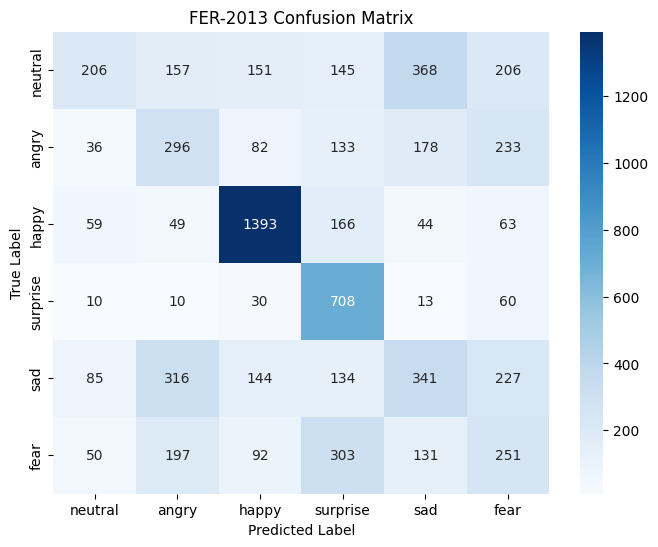

In [ ]:
# fer2013 confusion matrix
test_generator.reset()
fer_all_predictions = model.predict(test_generator)
fer_all_pred_labels = np.argmax(fer_all_predictions, axis=1)
fer_all_true_labels = test_generator.classes

fer_cm = confusion_matrix(fer_all_true_labels, fer_all_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(fer_cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('FER-2013 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/content/drive/MyDrive/fer_confusion_matrix.png')
plt.show()

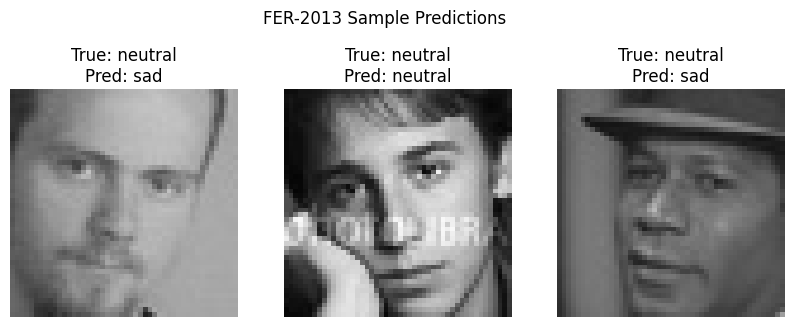

In [ ]:
# fer2013 sample predictions
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(fer_images[i])
    plt.title(f"True: {emotion_labels[fer_true_labels[i]]}\nPred: {emotion_labels[fer_pred_labels[i]]}")
    plt.axis('off')
plt.suptitle("FER-2013 Sample Predictions")
plt.savefig('/content/drive/MyDrive/fer_sample_predictions.png')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


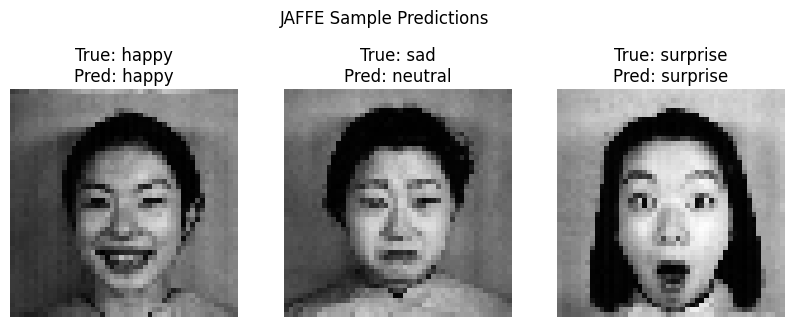

In [ ]:
# jaffe predictions
jaffe_predictions = model.predict(X_test_jaffe)
jaffe_pred_labels = np.argmax(jaffe_predictions, axis=1)
jaffe_true_labels = np.argmax(y_test_jaffe, axis=1)

plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(X_test_jaffe[i])
    plt.title(f"True: {emotion_labels[jaffe_true_labels[i]]}\nPred: {emotion_labels[jaffe_pred_labels[i]]}")
    plt.axis('off')
plt.suptitle("JAFFE Sample Predictions")
plt.savefig('/content/drive/MyDrive/jaffe_sample_predictions.png')
plt.show()


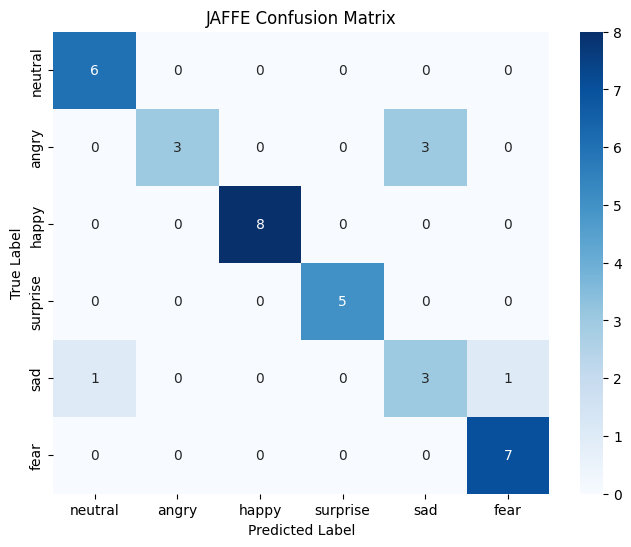

In [ ]:
#jaffe confusion matrix
jaffe_cm = confusion_matrix(jaffe_true_labels, jaffe_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(jaffe_cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('JAFFE Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/content/drive/MyDrive/jaffe_confusion_matrix.png')
plt.show()

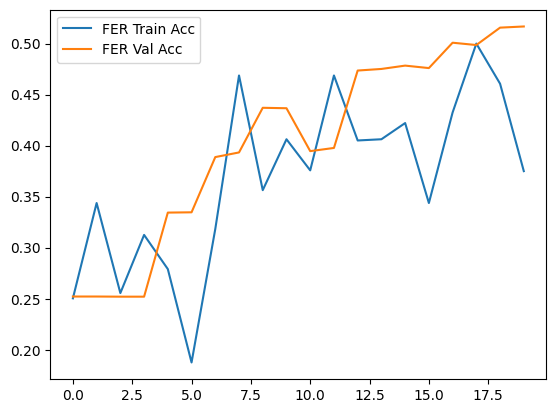

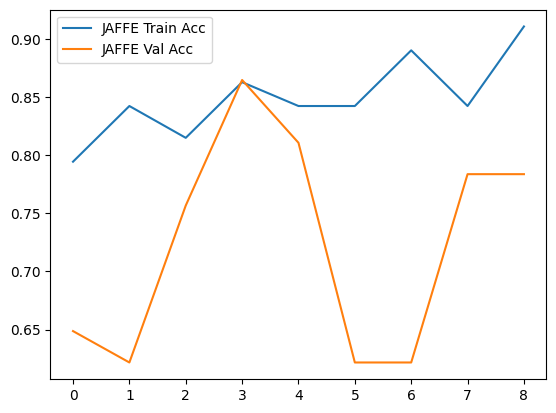

In [ ]:
plt.plot(history_fer.history['accuracy'], label='FER Train Acc')
plt.plot(history_fer.history['val_accuracy'], label='FER Val Acc')
plt.legend()
plt.show()
plt.plot(history_jaffe.history['accuracy'], label='JAFFE Train Acc')
plt.plot(history_jaffe.history['val_accuracy'], label='JAFFE Val Acc')
plt.legend()
plt.show()